<a href="https://colab.research.google.com/github/yukizaka/prediction-of-customer-churn/blob/main/Prediction_of_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time
import plotly.express as px
import io
# Classifier Libraries
from sklearn.svm import SVC
import collections

from sklearn.preprocessing import MinMaxScaler
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


# Data Preparation



## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FGA/train.csv')

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FGA/test.csv')

In [4]:
df_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [6]:
def get_cat_cols(df):
    num=list(df.columns[df.dtypes=='object'])
    return num
    
def get_num_cols(df):
    cat=list(df.columns[df.dtypes=='int64'])+list(df.columns[df.dtypes=='int32'])+list(df.columns[df.dtypes=='float64'])
    return cat

## EDA

### Data Quality Checking

In [7]:
#function for missing value

def missing (df_train):
    missing_number = df_train.isnull().sum().sort_values(ascending=False)
    missing_percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df_train)

,Missing_Number,Missing_Percent
state,0,0.0
account_length,0,0.0
number_customer_service_calls,0,0.0
total_intl_charge,0,0.0
total_intl_calls,0,0.0
total_intl_minutes,0,0.0
total_night_charge,0,0.0
total_night_calls,0,0.0
total_night_minutes,0,0.0
total_eve_charge,0,0.0


In [8]:
#function for duplicated value

def duplicate(df_train):
    dups = df_train.duplicated().sum()
    return dups

duplicate(df_train)

0

In [9]:
#function to change churn value

df_train['churn'] = df_train['churn'].map({'yes':1,'no':0})

### Descriptive Statistics

In [10]:
df_train.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059,0.140706
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434,0.347759
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000,0.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000,0.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


### Target Variable Distribution Test

In [11]:
target_variable_test = 'id'

In [12]:
df_test[target_variable_test].value_counts()

1      1
504    1
495    1
496    1
497    1
      ..
253    1
254    1
255    1
256    1
750    1
Name: id, Length: 750, dtype: int64

###Target Variable Distribution Train

In [13]:
target_variable = 'churn'

In [14]:
df_train[target_variable].value_counts()

0    3652
1     598
Name: churn, dtype: int64

In [15]:
df_train[target_variable].value_counts(normalize=True)

0    0.859294
1    0.140706
Name: churn, dtype: float64

In [16]:
print('No Churn', round(df_train[target_variable].value_counts()[0]/len(df_train) * 100,2), '% of the dataset')
print('Churn', round(df_train[target_variable].value_counts()[1]/len(df_train) * 100,2), '% of the dataset')

No Churn 85.93 % of the dataset
Churn 14.07 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Churn || 1: Churn)')

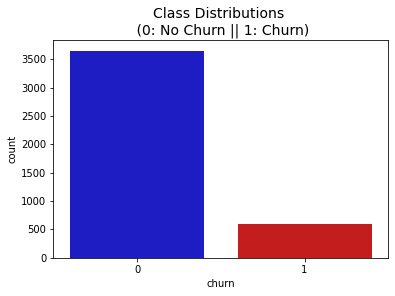

In [17]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('churn', data=df_train, palette=colors)
plt.title('Class Distributions \n (0: No Churn || 1: Churn)', fontsize=14)

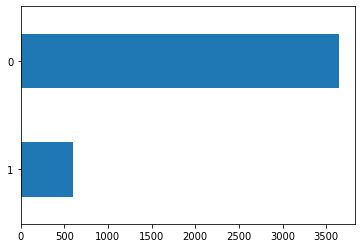

In [18]:
df_train[target_variable].value_counts().sort_values().plot(kind = 'barh')

### Numerical Feature Distribution Test

In [19]:
num_col_test = get_num_cols(df_test.drop(target_variable_test, axis=1))
num_col_test

['account_length',
 'number_vmail_messages',
 'total_day_calls',
 'total_eve_calls',
 'total_night_calls',
 'total_intl_calls',
 'number_customer_service_calls',
 'total_day_minutes',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_charge']

### Categorical Feature Distribution Test

In [20]:
cat_col_test = get_cat_cols(df_test)
cat_col_test

['state', 'area_code', 'international_plan', 'voice_mail_plan']

### Numerical Feature Distribution Train

In [21]:
num_col = get_num_cols(df_train.drop(target_variable, axis=1))
num_col

['account_length',
 'number_vmail_messages',
 'total_day_calls',
 'total_eve_calls',
 'total_night_calls',
 'total_intl_calls',
 'number_customer_service_calls',
 'total_day_minutes',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_charge']

In [22]:
import matplotlib.pyplot as plt
import plotly.express as px

for col in num_col:
  fig = px.histogram(df_train, x=col, marginal='box', width=500, height=400, color=target_variable)
  fig.show()

### Categorical Feature Distribution Train

In [23]:
cat_col = get_cat_cols(df_train)
cat_col

['state', 'area_code', 'international_plan', 'voice_mail_plan']

In [24]:
for i in cat_col:
  fig = px.histogram(df_train, x=i, width=500, height=400, color=target_variable, barmode="group")
  fig.show()

# Manual Process

## Data Prepocessing

###Normalization Numerical Feature Test.csv

In [25]:
scaler_test = MinMaxScaler()
X_transform_test = scaler_test.fit_transform(df_test[num_col_test])

In [26]:
X_transform_test = pd.DataFrame(X_transform_test,columns = num_col_test)
X_transform_test.head()

,account_length,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge
0,0.535865,0.490196,0.572581,0.488189,0.506410,0.157895,0.166667,0.746675,0.746653,0.499850,0.500000,0.618379,0.618440,0.529101,0.529412
1,0.493671,0.000000,0.475806,0.503937,0.679487,0.315789,0.000000,0.623411,0.623370,0.569624,0.569710,0.488194,0.488652,0.333333,0.333333
2,0.257384,0.000000,0.250000,0.307087,0.557692,0.315789,0.666667,0.319834,0.319770,0.830075,0.830149,0.485322,0.485816,0.693122,0.694118
3,0.388186,0.000000,0.604839,0.582677,0.698718,0.157895,0.500000,0.526751,0.526691,0.562406,0.562633,0.251117,0.251064,0.428571,0.429412
4,0.729958,0.000000,0.298387,0.590551,0.660256,0.263158,0.500000,0.330476,0.330377,0.739549,0.739561,0.637524,0.637589,0.820106,0.821569


In [27]:
df_test.shape

(750, 20)

###Normalization Numerical Feature Train.csv

In [28]:
scaler = MinMaxScaler()
X_transform = scaler.fit_transform(df_train[num_col])

In [29]:
X_transform = pd.DataFrame(X_transform,columns = num_col)
X_transform.head()

,account_length,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge
0,0.438017,0.500000,0.745455,0.605882,0.588571,0.15,0.111111,0.459744,0.459672,0.544114,0.544204,0.644051,0.644344,0.685,0.685185
1,0.561983,0.000000,0.690909,0.647059,0.594286,0.25,0.000000,0.692461,0.692436,0.337323,0.337263,0.411646,0.411930,0.610,0.609259
2,0.342975,0.000000,0.430303,0.517647,0.508571,0.35,0.222222,0.851778,0.851740,0.172279,0.172233,0.498481,0.498593,0.330,0.329630
3,0.305785,0.000000,0.684848,0.717647,0.691429,0.15,0.333333,0.474253,0.474230,0.412747,0.412901,0.473165,0.473270,0.505,0.505556
4,0.495868,0.461538,0.533333,0.635294,0.674286,0.35,0.333333,0.620768,0.620649,0.969942,0.969876,0.538228,0.538548,0.375,0.375926


In [30]:
df_train.shape

(4250, 20)

###One Hot Encoder - Categorical Feature Test.csv

In [31]:
cat_col_test

['state', 'area_code', 'international_plan', 'voice_mail_plan']

In [32]:
new_df_test = pd.concat([X_transform_test, df_test[cat_col_test], df_test[target_variable_test]], axis=1)
new_df_test.shape

(750, 20)

In [33]:
new_df_test.head()

,account_length,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge,state,area_code,international_plan,voice_mail_plan,id
0,0.535865,0.490196,0.572581,0.488189,0.506410,0.157895,0.166667,0.746675,0.746653,0.499850,0.500000,0.618379,0.618440,0.529101,0.529412,KS,area_code_415,no,yes,1
1,0.493671,0.000000,0.475806,0.503937,0.679487,0.315789,0.000000,0.623411,0.623370,0.569624,0.569710,0.488194,0.488652,0.333333,0.333333,AL,area_code_510,yes,no,2
2,0.257384,0.000000,0.250000,0.307087,0.557692,0.315789,0.666667,0.319834,0.319770,0.830075,0.830149,0.485322,0.485816,0.693122,0.694118,IA,area_code_415,no,no,3
3,0.388186,0.000000,0.604839,0.582677,0.698718,0.157895,0.500000,0.526751,0.526691,0.562406,0.562633,0.251117,0.251064,0.428571,0.429412,VT,area_code_510,no,no,4
4,0.729958,0.000000,0.298387,0.590551,0.660256,0.263158,0.500000,0.330476,0.330377,0.739549,0.739561,0.637524,0.637589,0.820106,0.821569,NE,area_code_415,no,no,5


In [34]:
new_df_test[target_variable_test] = new_df_test[target_variable_test].astype(int)

In [35]:
new_df_test = pd.get_dummies(new_df_test)
new_df_test.shape

(750, 74)

###One Hot Encoder - Categorical Feature Train.csv

In [36]:
cat_col

['state', 'area_code', 'international_plan', 'voice_mail_plan']

In [37]:
new_df_train = pd.concat([X_transform, df_train[cat_col], df_train[target_variable]], axis=1)
new_df_train.shape

(4250, 20)

In [38]:
new_df_train.head()

,account_length,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge,state,area_code,international_plan,voice_mail_plan,churn
0,0.438017,0.500000,0.745455,0.605882,0.588571,0.15,0.111111,0.459744,0.459672,0.544114,0.544204,0.644051,0.644344,0.685,0.685185,OH,area_code_415,no,yes,0
1,0.561983,0.000000,0.690909,0.647059,0.594286,0.25,0.000000,0.692461,0.692436,0.337323,0.337263,0.411646,0.411930,0.610,0.609259,NJ,area_code_415,no,no,0
2,0.342975,0.000000,0.430303,0.517647,0.508571,0.35,0.222222,0.851778,0.851740,0.172279,0.172233,0.498481,0.498593,0.330,0.329630,OH,area_code_408,yes,no,0
3,0.305785,0.000000,0.684848,0.717647,0.691429,0.15,0.333333,0.474253,0.474230,0.412747,0.412901,0.473165,0.473270,0.505,0.505556,OK,area_code_415,yes,no,0
4,0.495868,0.461538,0.533333,0.635294,0.674286,0.35,0.333333,0.620768,0.620649,0.969942,0.969876,0.538228,0.538548,0.375,0.375926,MA,area_code_510,no,yes,0


In [39]:
new_df_train[target_variable] = new_df_train[target_variable].astype(int)

In [40]:
new_df_train = pd.get_dummies(new_df_train)
new_df_train.shape

(4250, 74)

In [41]:
new_df_train.head()

,account_length,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls,total_day_minutes,total_day_charge,total_eve_minutes,...,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
0,0.438017,0.500000,0.745455,0.605882,0.588571,0.15,0.111111,0.459744,0.459672,0.544114,...,0,0,0,0,1,0,1,0,0,1
1,0.561983,0.000000,0.690909,0.647059,0.594286,0.25,0.000000,0.692461,0.692436,0.337323,...,0,0,0,0,1,0,1,0,1,0
2,0.342975,0.000000,0.430303,0.517647,0.508571,0.35,0.222222,0.851778,0.851740,0.172279,...,0,0,0,1,0,0,0,1,1,0
3,0.305785,0.000000,0.684848,0.717647,0.691429,0.15,0.333333,0.474253,0.474230,0.412747,...,0,0,0,0,1,0,0,1,1,0
4,0.495868,0.461538,0.533333,0.635294,0.674286,0.35,0.333333,0.620768,0.620649,0.969942,...,0,0,0,0,0,1,1,0,0,1


#Train Test Split Dataset

In [49]:
fitur_test = new_df_test.drop(target_variable_test, axis=1)
fitur_test.shape

(750, 73)

In [50]:
fitur_train = new_df_train.drop(target_variable, axis=1)
fitur_train.shape

(4250, 73)

In [51]:
label_train = new_df_train[[target_variable]]
label_train.describe()

,churn
count,4250.000000
mean,0.140706
std,0.347759
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [52]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(fitur_train, label_train, stratify=label_train,  random_state=123, test_size=0.3)

In [53]:
label_train.value_counts(normalize=True)

churn
0        0.859294
1        0.140706
dtype: float64

In [54]:
y_train.value_counts()

churn
0        2556
1         419
dtype: int64

In [55]:
y_test.value_counts(normalize=True)

churn
0        0.859608
1        0.140392
dtype: float64

#Undersampling

In [56]:
from imblearn.under_sampling import RandomUnderSampler

x_rus, y_rus = RandomUnderSampler().fit_resample(x_train, y_train)

In [57]:
y_rus.value_counts()

churn
0        419
1        419
dtype: int64

#Support Vector Machine and KNN- Supervised Classification

## Fit the SVM model with training data

In [58]:
def evaluasi_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

In [59]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(x_train, y_train)

LinearSVC()

In [60]:
y_pred = svc.predict(x_test)

In [61]:
evaluasi_model(svc, x_train, y_train)

0.5858801042798824

In [62]:
evaluasi_model(svc, x_test, y_test)

0.5803174570811076

## Fit the KNN model with training data

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [64]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [65]:
y_pred_knn = knn.predict(x_test)

In [66]:
evaluasi_model(knn, x_train, y_train)

0.6239878277887959

In [67]:
evaluasi_model(knn, x_test, y_test)

0.5537531093259389

### Accuracy, Precision, Recall and Confusion Matrix KNN

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_knn).ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
print(accuracy)

0.8596078431372549


In [69]:
precision_score(y_test, y_pred_knn, average=None)

array([0.87306753, 0.5       ])

In [70]:
recall_score(y_test, y_pred_knn, average=None)

array([0.9790146 , 0.12849162])

In [71]:
from sklearn import metrics

confusion_matrix1 = metrics.confusion_matrix(y_test, y_pred_knn)

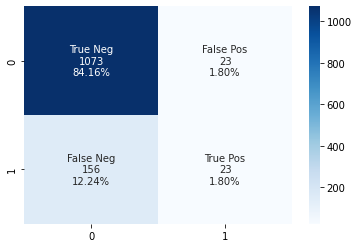

In [72]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix1.flatten()/np.sum(confusion_matrix1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix1, annot=labels, fmt="", cmap='Blues')

### Accuracy, Precision, Recall and Confusion Matrix SVM

In [73]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
print(accuracy)

0.8650980392156863


In [74]:
precision_score(y_test, y_pred, average=None)

array([0.87993421, 0.55932203])

In [75]:
recall_score(y_test, y_pred, average=None)

array([0.97627737, 0.18435754])

In [76]:
confusion_matrix(y_test, y_pred)

array([[1070,   26],
       [ 146,   33]])

In [77]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

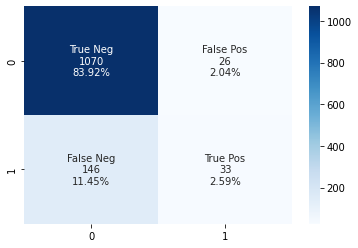

In [78]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt="", cmap='Blues')

## Perform SVM Classification Prediction using testing dataset

In [79]:
y_pred_test = svc.predict(fitur_test)
print(y_pred_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 

In [80]:
import numpy as np
(unique, counts) = np.unique(y_pred_test, return_counts=True)
frequencies = np.asarray((unique, counts/750)).T

print(frequencies)

[[0.         0.92266667]
 [1.         0.07733333]]


In [81]:
print(accuracy_score(y_test,y_pred))

0.8650980392156863


In [82]:
#tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#accuracy = (tn + tp)/(tn + fp + fn + tp)
#print(accuracy)

## Perform KNN Classification Prediction using testing dataset

In [83]:
y_pred_test1 = knn.predict(fitur_test)
print(y_pred_test1)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [84]:
(unique, counts) = np.unique(y_pred_test1, return_counts=True)
frequencies1 = np.asarray((unique, counts/750)).T

print(frequencies1)

[[0.    0.972]
 [1.    0.028]]


In [85]:
print(accuracy_score(y_test, y_pred_knn))

0.8596078431372549


In [86]:
#tn, fp, fn, tp = confusion_matrix1(y_test, y_pred_knn).ravel()
#accuracy1 = (tn + tp)/(tn + fp + fn + tp)
#print(accuracy1)

##Under Sampling SVM

In [87]:
svc_rus = LinearSVC()
svc_rus.fit(x_rus, y_rus)

LinearSVC()

In [88]:
y_pred_rus = svc_rus.predict(x_test)

In [89]:
evaluasi_model(svc_rus, x_rus, y_rus)

0.7971360381861574

In [90]:
y_pred_test_rus = svc_rus.predict(fitur_test)
print(y_pred_test_rus)

[0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1
 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0
 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0
 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0
 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0
 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0
 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1
 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0
 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1
 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0
 1 1 0 1 1 0 1 0 1 0 0 1 

In [91]:
(unique, counts) = np.unique(y_pred_test_rus, return_counts=True)
frequencies_rus = np.asarray((unique, counts/750)).T

print(frequencies_rus)

[[0.         0.55733333]
 [1.         0.44266667]]


## Under Sampling KNN

In [92]:
knn_rus = KNeighborsClassifier()
knn_rus.fit(x_rus, y_rus)

KNeighborsClassifier()

In [93]:
y_pred_rus_knn = knn_rus.predict(x_test)

In [94]:
evaluasi_model(knn_rus, x_rus, y_rus)

0.7947494033412889

In [95]:
y_pred_test_rus_knn = knn_rus.predict(fitur_test)
print(y_pred_test_rus_knn)

[0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0
 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1
 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1
 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1
 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0
 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1
 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0
 1 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0
 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0
 0 1 0 1 1 0 0 1 1 0 1 1 

In [96]:
(unique, counts) = np.unique(y_pred_test_rus_knn, return_counts=True)
frequencies_rus_knn = np.asarray((unique, counts/750)).T

print(frequencies_rus_knn)

[[0.    0.608]
 [1.    0.392]]


#Pipeline Process

In [97]:
df_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0


In [98]:
dftrain, dftest = train_test_split(df_train, test_size=0.2, stratify=df_train[target_variable])

In [99]:
y_train = dftrain[target_variable]
x_train = dftrain.drop(columns=target_variable)

y_test = dftest[target_variable]
x_test = dftest.drop(columns=target_variable)

In [100]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 792 kB/s 


##Define Preprocess Using Column Transformer

In [101]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.ensemble import *
from category_encoders import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier


preprocess = ColumnTransformer(
    [
        ('categorical', BaseNEncoder(), cat_col),
        ('scaler', MinMaxScaler(), num_col)
    ],
    remainder='passthrough'
)

clf_list = [KNeighborsClassifier(), LinearSVC(random_state=123)]

##Define Pipeline

In [102]:
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score,f1_score
from imblearn.under_sampling import RandomUnderSampler

def get_score(model, fitur_train, label_train):
    pred = model.predict(fitur_train)
    auc = roc_auc_score(label_train, pred)
    prec = precision_score(label_train, pred)
    rec = recall_score(label_train, pred)
    return auc, prec, rec

train_scores = []
test_scores = []
models = []
for clf in clf_list:
    model = Pipeline(
        [
            ('preprocessor', preprocess),
            # ('rus', RandomUnderSampler()), #silakan dmainkan bagian sini, coba tes dengan RUS atau tanpa RUS
            ('clf', clf)
        ]
    )
    model.fit(x_train, y_train)
    train_score = get_score(model, x_train, y_train)
    test_score = get_score(model, x_test, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(type(clf).__name__)
    models.append(type(clf).__name__)

KNeighborsClassifier
LinearSVC


## Evaluasi Model

In [103]:
df_eval = pd.DataFrame()
df_eval['model'] = models
df_eval['train_auc'] = [x[0] for x in train_scores]
df_eval['train_precision'] = [x[1] for x in train_scores]
df_eval['train_recall'] = [x[2] for x in train_scores]
df_eval['test_auc'] = [x[0] for x in test_scores]
df_eval['test_precision'] = [x[1] for x in test_scores]
df_eval['test_recall'] = [x[2] for x in test_scores]

In [104]:
df_eval

,model,train_auc,train_precision,train_recall,test_auc,test_precision,test_recall
0,KNeighborsClassifier,0.623718,0.779874,0.259414,0.538299,0.500000,0.091667
1,LinearSVC,0.560976,0.613208,0.135983,0.584132,0.666667,0.183333


In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc